In [3]:
import pickle
from functools import reduce

import sagemaker
from sagemaker.estimator import Estimator
from sagemaker.tuner import (
    ContinuousParameter,
    IntegerParameter,
    CategoricalParameter,
    HyperparameterTuner,
)
import boto3

import cudf
import cupy as cp
import numpy as np
from sklearn.pipeline import Pipeline
from cuml.preprocessing import MaxAbsScaler
from cuml import TruncatedSVD

import matplotlib.pyplot as plt

## S3

In [4]:
s3_bucket = "yang-ml-sagemaker"
s3_key = "otto-product-classification"

s3_check_point = f"s3://{s3_bucket}/{s3_key}/checkpoint"

s3 = boto3.client("s3")

train_channel = {
    "train": sagemaker.inputs.TrainingInput(
        s3_data=f"s3://{s3_bucket}/{s3_key}/train/",
        distribution="FullyReplicated",
        s3_data_type="S3Prefix",
    )
}

train_channel

{'train': <sagemaker.inputs.TrainingInput at 0x7fab80814a60>}

## Sagemaker

In [5]:
sagemaker_session = sagemaker.Session(default_bucket=s3_bucket)
sagemaker_session
sm_boto3 = boto3.client("sagemaker")
role = sagemaker.get_execution_role()

instance_type = "ml.p3.2xlarge"
instance_count = 1
train_use_spot_instances = True
max_run = 24 * 60 * 60
max_retry_attempts = 2

baseline_image_uri = "722696965592.dkr.ecr.us-east-1.amazonaws.com/ml-sagemaker:23.04-cuda11.8-base-ubuntu22.04-py3.10-sagemaker-baseline"
model_dir = "/opt/ml/model"

## Data

In [ ]:
df = cudf.read_parquet(
    train_channel["train"].config["DataSource"]["S3DataSource"]["S3Uri"]
    + "train.parquet"
)
df.shape

In [31]:
df.head(10)

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
id,,,,,,,,,,,,,,,,,,,,,
53745,0,0,0,0,0,0,0,1,3,5,...,0,1,0,0,0,2,0,0,2,7
31272,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
39547,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,2,0,5
58666,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,1,0,8
52734,0,1,0,0,0,0,0,0,0,0,...,0,2,0,0,0,26,0,0,0,7
28492,0,0,0,0,0,0,0,0,0,0,...,0,2,0,1,0,0,0,1,1,3
2661,0,0,0,0,0,0,0,0,0,0,...,1,2,0,2,0,0,0,0,0,1
39075,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
55589,11,1,0,0,0,0,3,1,0,0,...,1,0,1,0,0,1,1,0,1,7


### Data Types

In [74]:
df.dtypes

feat_1      int64
feat_2      int64
feat_3      int64
feat_4      int64
feat_5      int64
            ...  
feat_90     int64
feat_91     int64
feat_92     int64
feat_93     int64
target     object
Length: 94, dtype: object

In [32]:
# Convert to int8
df = df.astype(
    {
        col: dtype
        for col, dtype in zip(df.columns, ["int8"] * (df.shape[1] - 1) + ["string"])
    }
)
df.dtypes

feat_1               int8
feat_2               int8
feat_3               int8
feat_4               int8
feat_5               int8
                ...      
feat_90              int8
feat_91              int8
feat_92              int8
feat_93              int8
target     string[python]
Length: 94, dtype: object

### Missingness

In [33]:
df.isna().any().sum(axis=0)

0

### Sparsity

In [97]:
num_rows = df.shape[0]
pct_non_zeros = (
    df.drop("target", axis=1).applymap(lambda col: 1 if col != 0 else 0).sum()
).values / num_rows
pct_non_zeros

array([0.16799185, 0.11086331, 0.20335176, 0.21703998, 0.04801383,
       0.01887585, 0.08783413, 0.26772035, 0.19460875, 0.12416368,
       0.27206762, 0.1056272 , 0.18500921, 0.44177252, 0.29264036,
       0.48852581, 0.16370923, 0.28832541, 0.09302175, 0.20740813,
       0.11852355, 0.33945829, 0.07123695, 0.6432173 , 0.55889007,
       0.20521025, 0.1462717 , 0.12716959, 0.11889525, 0.07962442,
       0.07335402, 0.32185914, 0.3570736 , 0.25382204, 0.22347199,
       0.2508646 , 0.16804034, 0.2601086 , 0.13371473, 0.47326998,
       0.1804357 , 0.28363877, 0.16592327, 0.27143734, 0.06233233,
       0.16091341, 0.08387472, 0.5446847 , 0.1665697 , 0.13552474,
       0.02778047, 0.09919519, 0.19624099, 0.45746469, 0.18373251,
       0.11645496, 0.14905136, 0.1347167 , 0.10982902, 0.24920004,
       0.09378131, 0.42818126, 0.09736902, 0.35232231, 0.14822716,
       0.28323475, 0.61327128, 0.14114871, 0.14066389, 0.34967194,
       0.16783025, 0.28900417, 0.16728078, 0.19119881, 0.21510

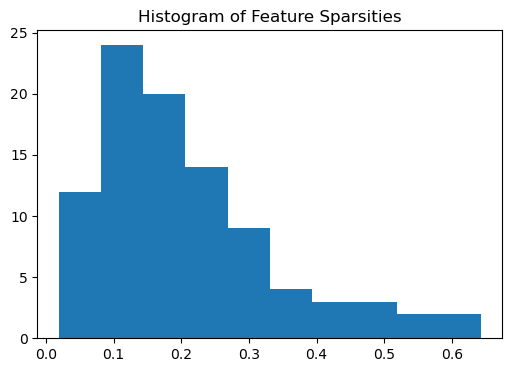

In [101]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.hist(pct_non_zeros.get())
plt.title("Histogram of Feature Sparsities")
plt.show()

### Feature Ranges

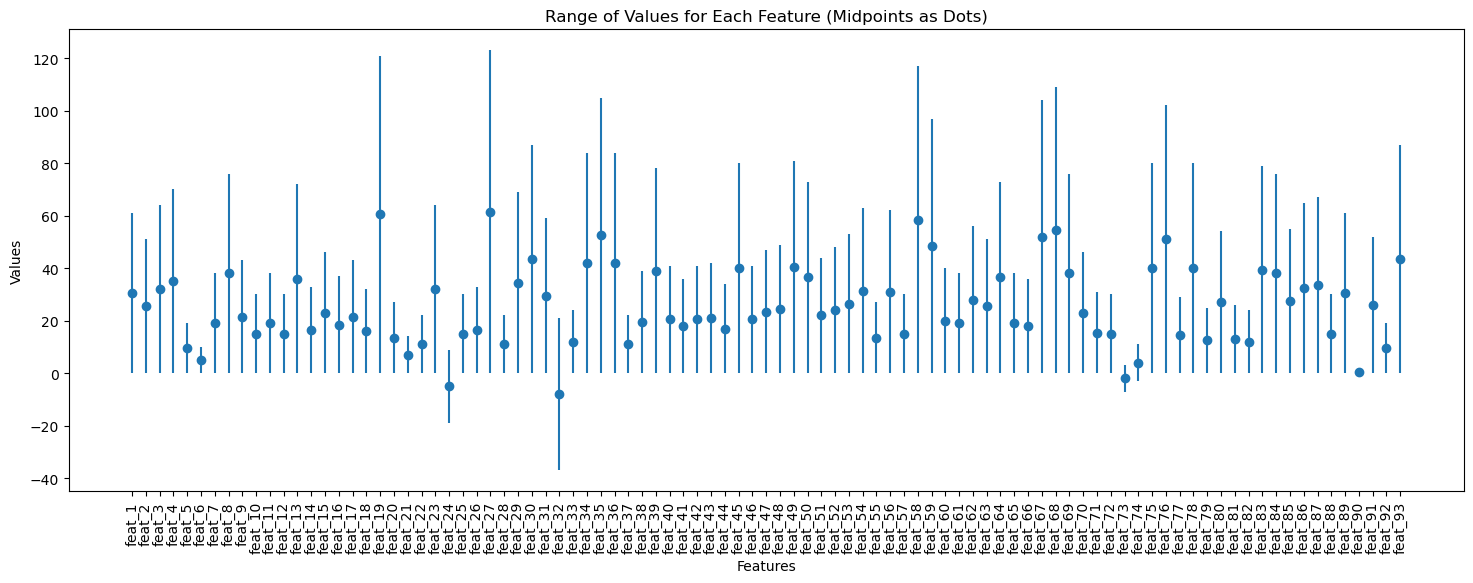

In [122]:
feature_max_values = df.drop("target", axis=1).max(axis=0).values
feature_min_values = df.drop("target", axis=1).min(axis=0).values
feature_range = feature_max_values - feature_min_values
feature_labels = df.drop("target", axis=1).columns.tolist()

fig, ax = plt.subplots(figsize=(18, 6))
ax.errorbar(
    x=feature_labels,
    y=(feature_max_values.get() + feature_min_values.get()) / 2,
    yerr=np.abs(feature_range.get()) / 2,
    fmt="o",
)
ax.set_xlabel("Features")
ax.set_ylabel("Values")
ax.set_title("Range of Values for Each Feature (Midpoints as Dots)")
plt.xticks(rotation="vertical")
plt.show();

## Target Class Distributions

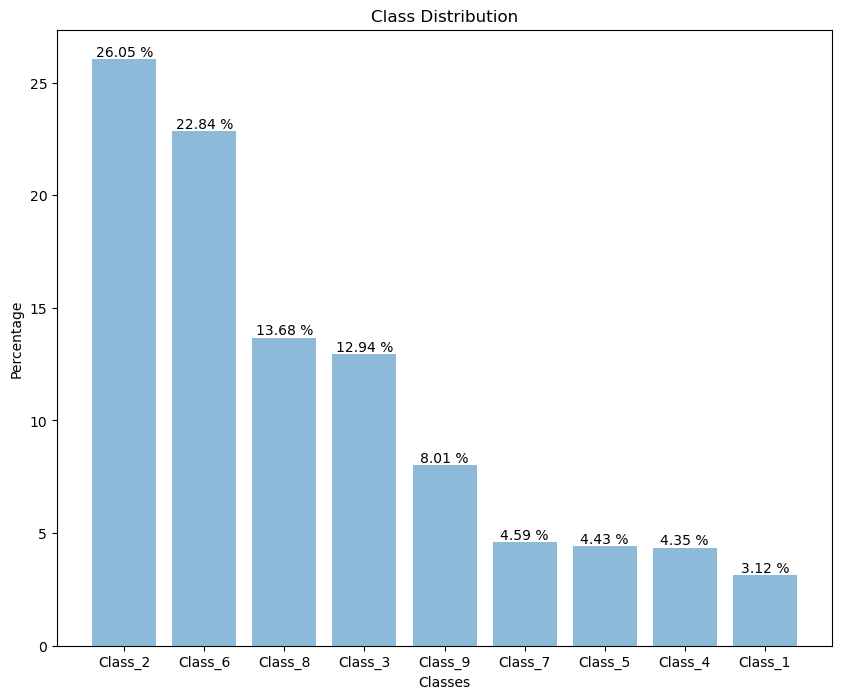

In [222]:
# Feature matrix
X = df.drop("target", axis=1)
y = df.target

class_dist = (y.value_counts() / len(y) * 100).to_dict()

fig, ax = plt.subplots(figsize=(10, 8))
bar_plot = ax.bar(class_dist.keys(), class_dist.values(), alpha=0.5)
ax.set_xlabel("Classes")
ax.set_ylabel("Percentage")
ax.set_title("Class Distribution")
for rect in bar_plot:
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        height,
        f"{height:.2f} %",
        ha="center",
        va="bottom",
    )
plt.show();

The data is imbalanced.

## Truncated SVD

In [225]:
svd_pipeline = Pipeline(
    [
        ("scaler", MaxAbsScaler()),  # To avoid destroying any sparsity
        ("svd", TruncatedSVD(n_components=X.shape[1])),
    ]
)

svd_pipeline.fit(X=X, y=y)

Pipeline(steps=[('scaler', MaxAbsScaler()), ('svd', TruncatedSVD())])

Plot the percentage variance explained by each component:

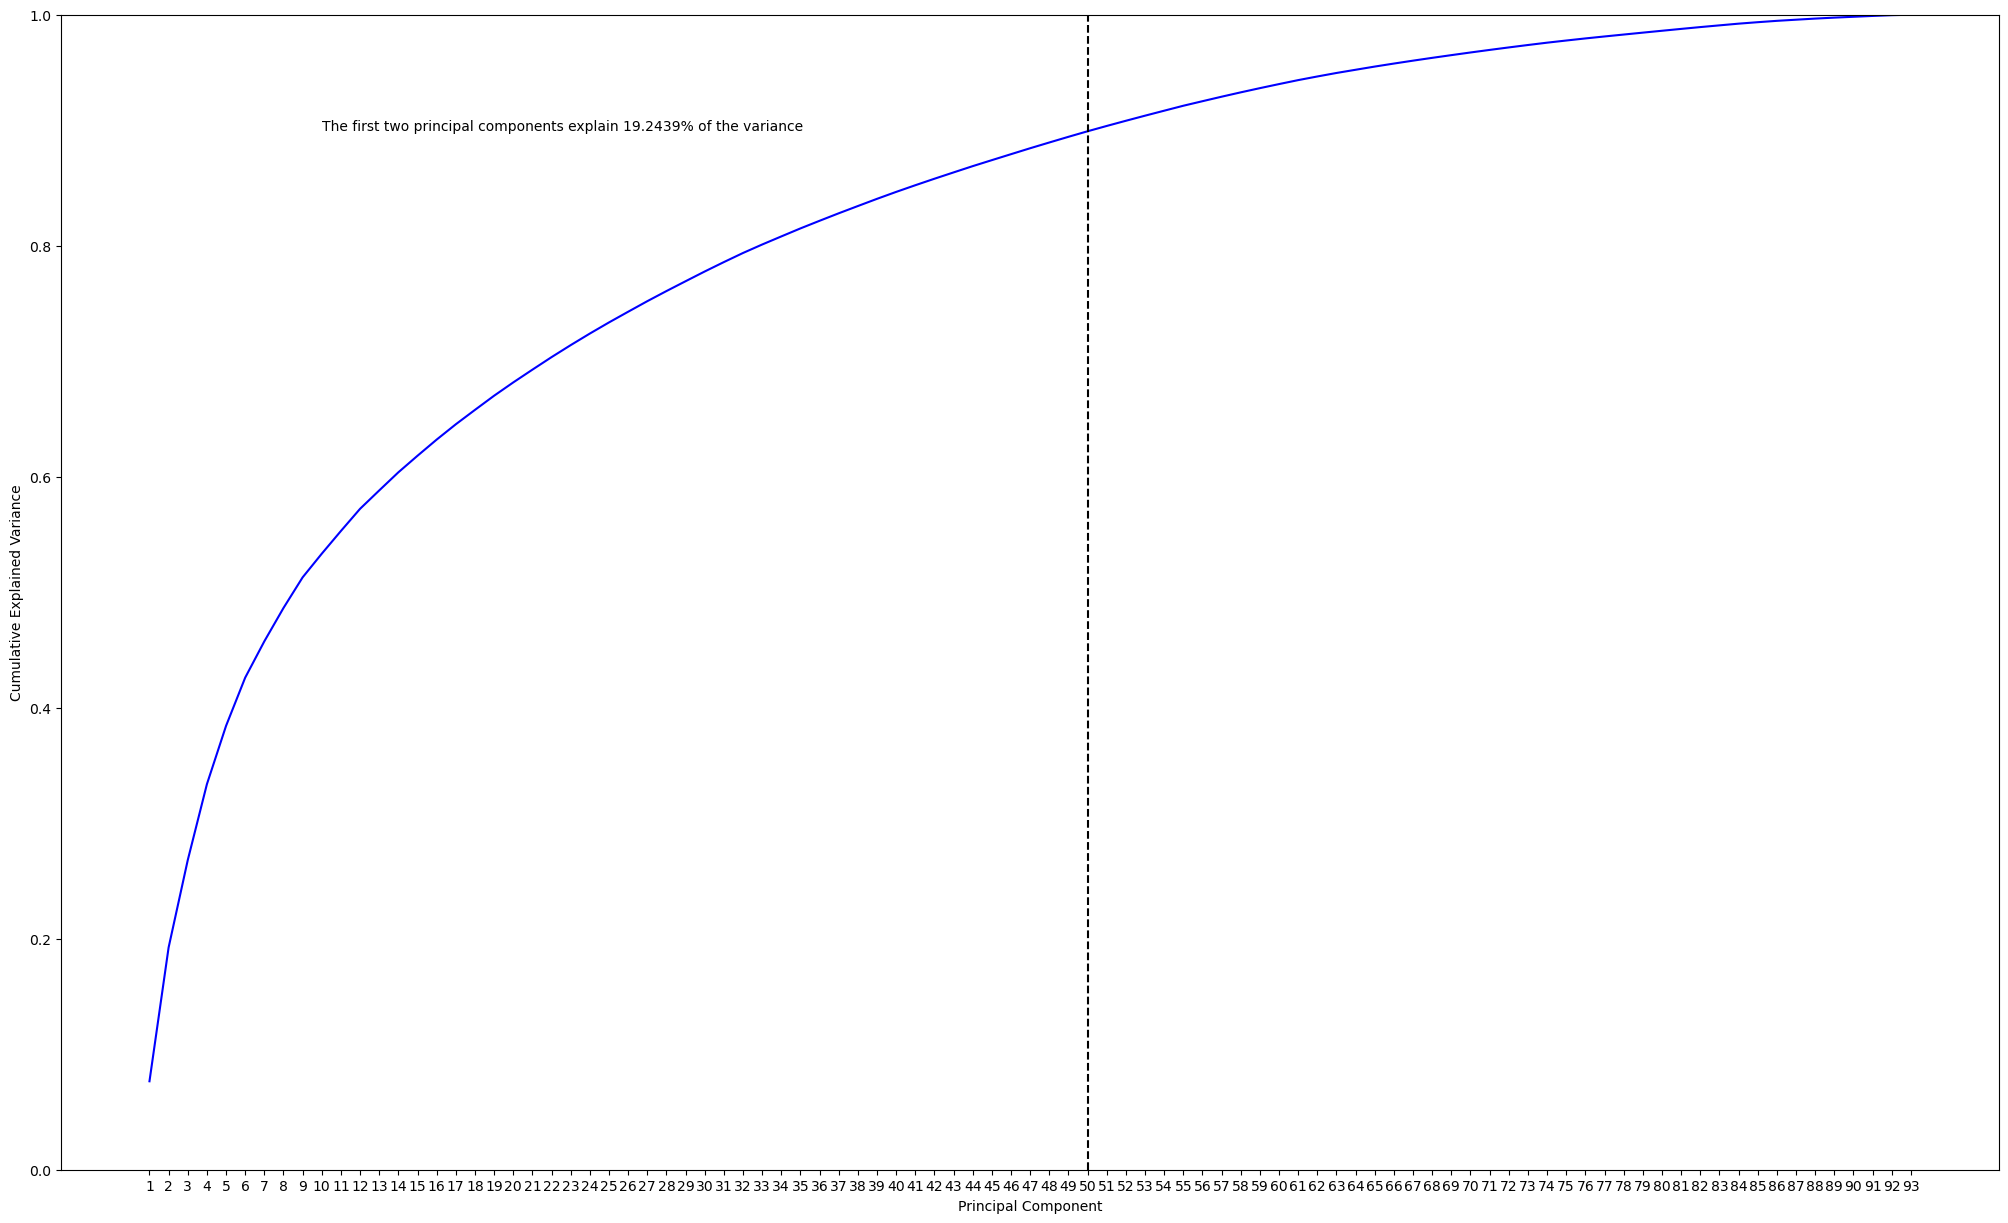

In [226]:
# Cumulative explained variance
cum_exp_var = cp.cumsum(svd_pipeline["svd"].explained_variance_ratio_.values).get()
component_indices = range(1, X.shape[1] + 1)
num_components_90 = np.where(cum_exp_var > 0.9)[0][0]

fig, ax = plt.subplots(figsize=(25, 15))

plt.plot(component_indices, cum_exp_var, color="blue")
plt.ylim(0, 1)
plt.xticks(component_indices)
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance")
plt.axvline(x=num_components_90, color="black", linestyle="--")
plt.text(
    10,
    0.9,
    f"The first two principal components explain {round(cum_exp_var[1] * 100, 4)}% of the variance",
    color="black",
)
plt.show();

The data matrix has a lower intrinsic dimension than the original dimension.

## Baseline XGBoost For Feature Importance

In [6]:
# Custom training image
baseline_estimator = Estimator(
    image_uri=baseline_image_uri,
    role=role,
    instance_type=instance_type,
    instance_count=instance_count,
    volume_size=30,
    output_path=f"s3://{s3_bucket}/{s3_key}/model",
    sagemaker_session=sagemaker_session,
    base_job_name="baseline-training",
    use_spot_instances=train_use_spot_instances,
    max_wait=max_run,  # This should be equal to or greater than max_run
    checkpoint_s3_uri=s3_check_point + "/baseline",
)
baseline_estimator

### Hyperparameter Optimization

In [7]:
search_space = {
    "n_estimators": IntegerParameter(min_value=500, max_value=1700),
    "max_depth": IntegerParameter(min_value=3, max_value=15),
    "learning_rate": ContinuousParameter(
        min_value=1e-3, max_value=0.8, scaling_type="Logarithmic"
    ),
    "gamma": ContinuousParameter(min_value=1, max_value=20),
    "max_delta_step": IntegerParameter(min_value=1, max_value=20),
    "min_child_weight": ContinuousParameter(
        min_value=0, max_value=20
    ),  # Smaller values since this is a imbalanced dataset and small number of samples from a minority class can be in a leaf
    "max_leaves": IntegerParameter(min_value=0, max_value=50),
    "subsample": ContinuousParameter(min_value=0.5, max_value=0.9),
    "colsample_bytree": ContinuousParameter(min_value=0.2, max_value=0.9),
    "colsample_bylevel": ContinuousParameter(min_value=0.2, max_value=0.9),
    "colsample_bynode": ContinuousParameter(min_value=0.2, max_value=0.9),
    "reg_alpha": ContinuousParameter(min_value=0.01, max_value=100),
    "reg_lambda": ContinuousParameter(min_value=0.01, max_value=100),
    "max_bin": CategoricalParameter(values=[2**i for i in range(8, 11)]),
}

objective_metric_name = "mlogloss"
objective_type = "Minimize"
metric_definitions = [
    {
        "Name": objective_metric_name,
        "Regex": "Mean logloss score: ([0-9\\.]+)",
    }
]
base_tuning_job_name = f"baseline-hpo"

In [13]:
hpo_tuner = HyperparameterTuner(
    estimator=baseline_estimator,
    objective_metric_name=objective_metric_name,
    hyperparameter_ranges=search_space,
    metric_definitions=metric_definitions,
    strategy="Bayesian",
    objective_type=objective_type,
    max_jobs=50,
    max_parallel_jobs=10,
    base_tuning_job_name=base_tuning_job_name,
)

In [14]:
hpo_tuner.fit(train_channel)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.............................................................................................................................................................................................................................................................................................................................................................................................................................!


Check hpo results:

In [17]:
hpo_analytics = sagemaker.HyperparameterTuningJobAnalytics(
    hpo_tuner.latest_tuning_job.name
)

hpo_results = hpo_analytics.dataframe()

hpo_results.sort_values("FinalObjectiveValue", ascending=True).head(10)

,colsample_bylevel,colsample_bynode,colsample_bytree,gamma,learning_rate,max_bin,max_delta_step,max_depth,max_leaves,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
1,0.845307,0.806384,0.900000,3.808997,0.800000,256.0,20.0,10.0,50.0,9.015639,1075.0,0.125790,0.081533,0.704987,baseline-hpo-230618-0706-049-66d4d21a,Completed,1.147912,2023-06-18 07:36:36+00:00,2023-06-18 07:40:28+00:00,232.0
23,0.745660,0.546783,0.900000,10.715929,0.800000,512.0,8.0,9.0,50.0,7.177385,1633.0,0.739104,0.153431,0.846868,baseline-hpo-230618-0706-027-9c3ae413,Completed,1.203558,2023-06-18 07:22:58+00:00,2023-06-18 07:26:45+00:00,227.0
0,0.900000,0.660926,0.900000,18.340258,0.800000,1024.0,5.0,9.0,50.0,10.993972,1179.0,0.122154,0.131177,0.567283,baseline-hpo-230618-0706-050-9ed67e9a,Completed,1.229038,2023-06-18 07:36:43+00:00,2023-06-18 07:40:40+00:00,237.0
29,0.778588,0.579310,0.900000,16.390232,0.800000,512.0,10.0,11.0,38.0,17.587405,1348.0,0.200289,0.123722,0.900000,baseline-hpo-230618-0706-021-55979640,Completed,1.235469,2023-06-18 07:22:53+00:00,2023-06-18 07:26:45+00:00,232.0
8,0.509038,0.621697,0.900000,17.149861,0.800000,256.0,4.0,9.0,50.0,13.310454,841.0,0.012582,0.103999,0.860605,baseline-hpo-230618-0706-042-95f1905c,Completed,1.254044,2023-06-18 07:34:58+00:00,2023-06-18 07:38:45+00:00,227.0
2,0.900000,0.382537,0.824708,7.280245,0.800000,512.0,18.0,10.0,50.0,11.422221,1484.0,15.599967,0.052360,0.775616,baseline-hpo-230618-0706-048-7cd43f77,Completed,1.323917,2023-06-18 07:35:35+00:00,2023-06-18 07:39:29+00:00,234.0
12,0.514508,0.867310,0.900000,8.505867,0.800000,256.0,2.0,12.0,50.0,7.177718,780.0,0.128432,3.882816,0.851415,baseline-hpo-230618-0706-038-af6ff429,Completed,1.360738,2023-06-18 07:29:12+00:00,2023-06-18 07:32:59+00:00,227.0
34,0.591391,0.526009,0.862126,2.240197,0.635676,512.0,8.0,10.0,38.0,18.763804,786.0,0.475925,0.010000,0.894196,baseline-hpo-230618-0706-016-64c3f664,Completed,1.363195,2023-06-18 07:17:09+00:00,2023-06-18 07:21:01+00:00,232.0
4,0.837928,0.640196,0.868737,8.455886,0.642281,512.0,5.0,9.0,12.0,15.475815,809.0,0.036901,0.495808,0.643648,baseline-hpo-230618-0706-046-251e06c5,Completed,1.405153,2023-06-18 07:35:29+00:00,2023-06-18 07:39:21+00:00,232.0
21,0.753948,0.589278,0.344437,1.000000,0.800000,256.0,15.0,10.0,37.0,20.000000,851.0,0.018289,0.214527,0.900000,baseline-hpo-230618-0706-029-1ea0171d,Completed,1.448543,2023-06-18 07:23:10+00:00,2023-06-18 07:26:58+00:00,228.0


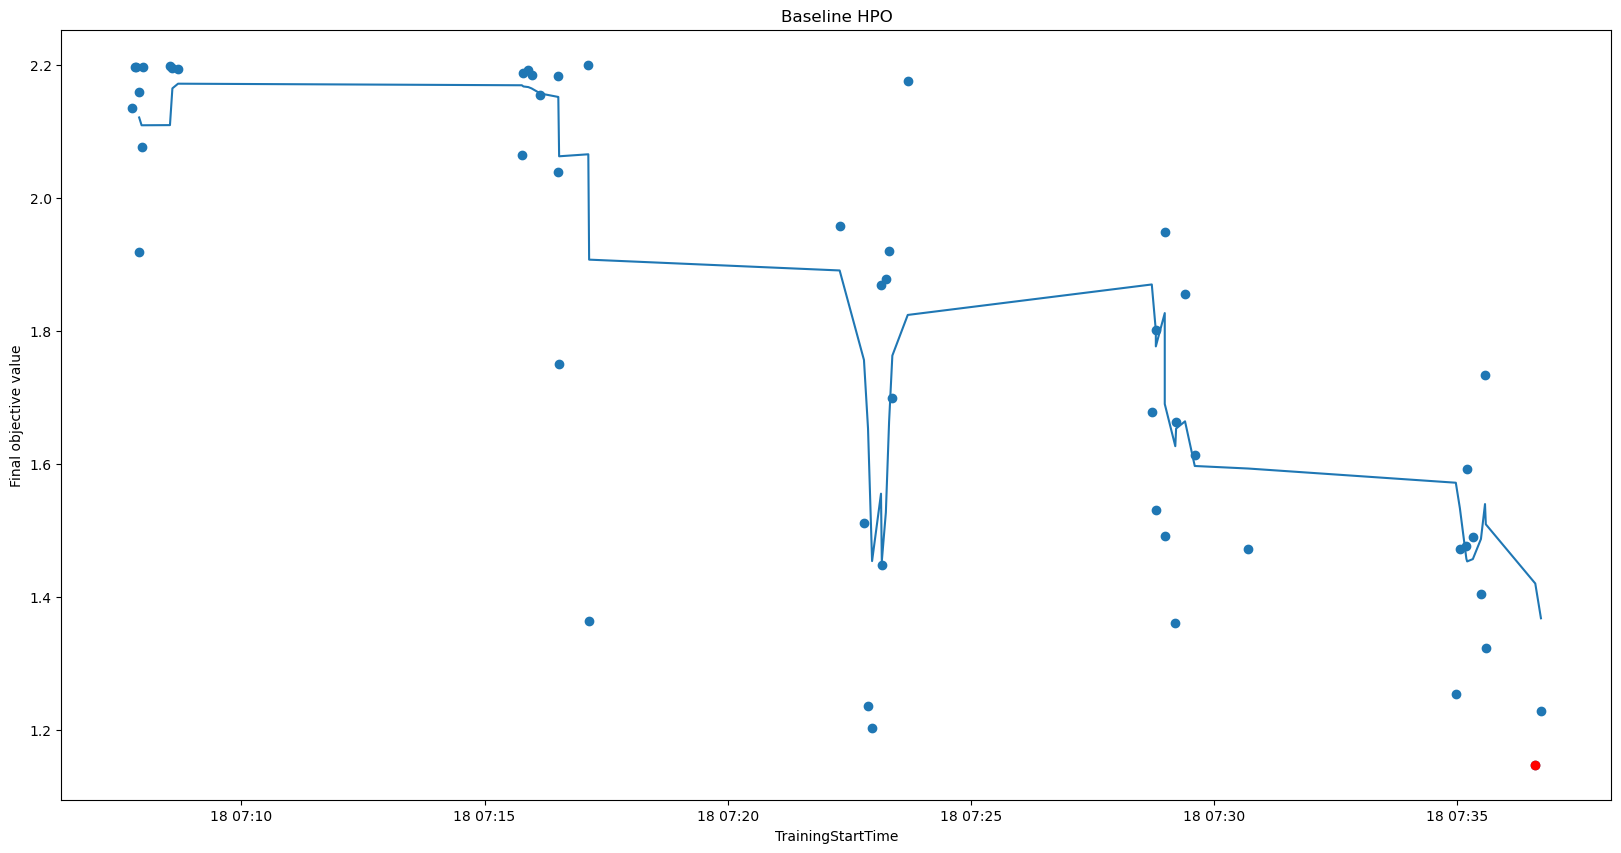

In [19]:
plt.figure(figsize=(20, 10))
# Sort by TrainingStartTime
hpo_results.sort_values("TrainingStartTime", inplace=True)
plt.scatter(hpo_results["TrainingStartTime"], hpo_results["FinalObjectiveValue"])
plt.plot(
    hpo_results["TrainingStartTime"],
    hpo_results["FinalObjectiveValue"].rolling(5).mean(),
)
# Highlight the best score in red
plt.scatter(
    hpo_results["TrainingStartTime"][hpo_results["FinalObjectiveValue"].idxmin()],
    hpo_results["FinalObjectiveValue"].min(),
    c="r",
)
plt.xlabel("TrainingStartTime")
plt.ylabel("Final objective value")
plt.title("Baseline HPO")
plt.show();

### Feature Importance

In [20]:
best_model_name = sm_boto3.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=hpo_tuner.latest_tuning_job.name
)["BestTrainingJob"]["TrainingJobName"]

feature_importances = pickle.loads(
    s3.get_object(
        Bucket=s3_bucket,
        Key=f"{s3_key}/eda/{best_model_name}-feature-importances.pickle",
    )["Body"].read()
)

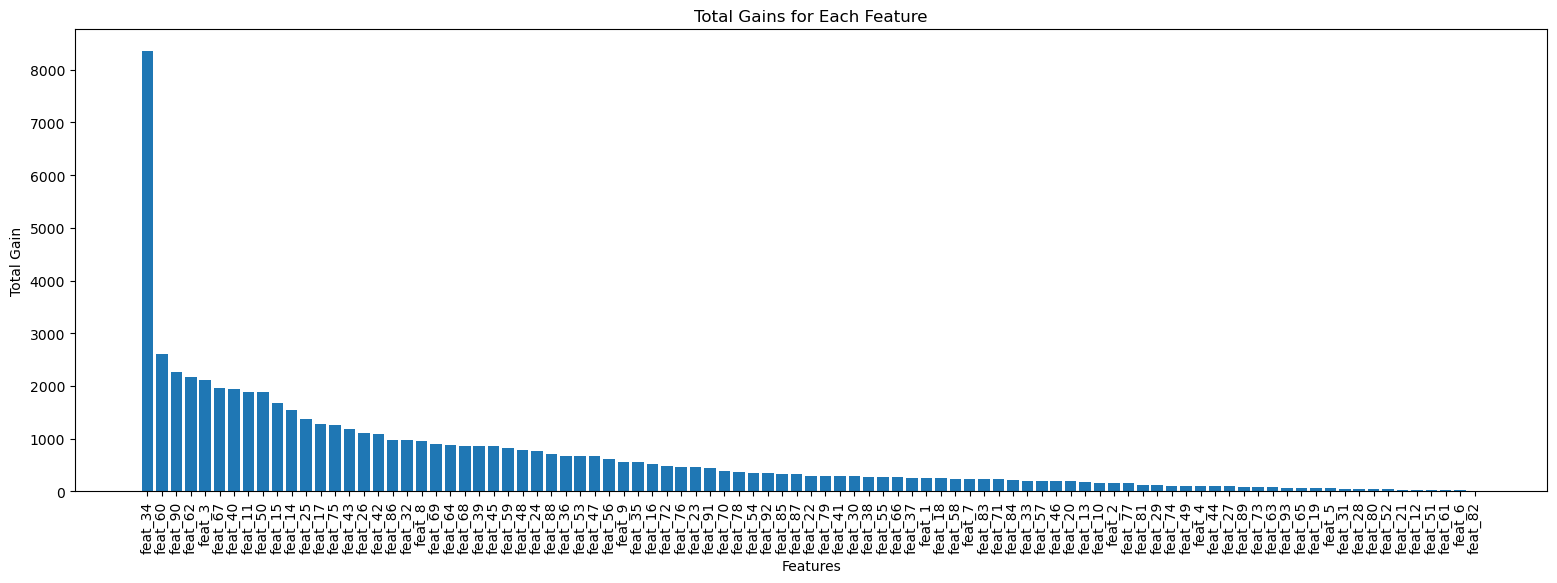

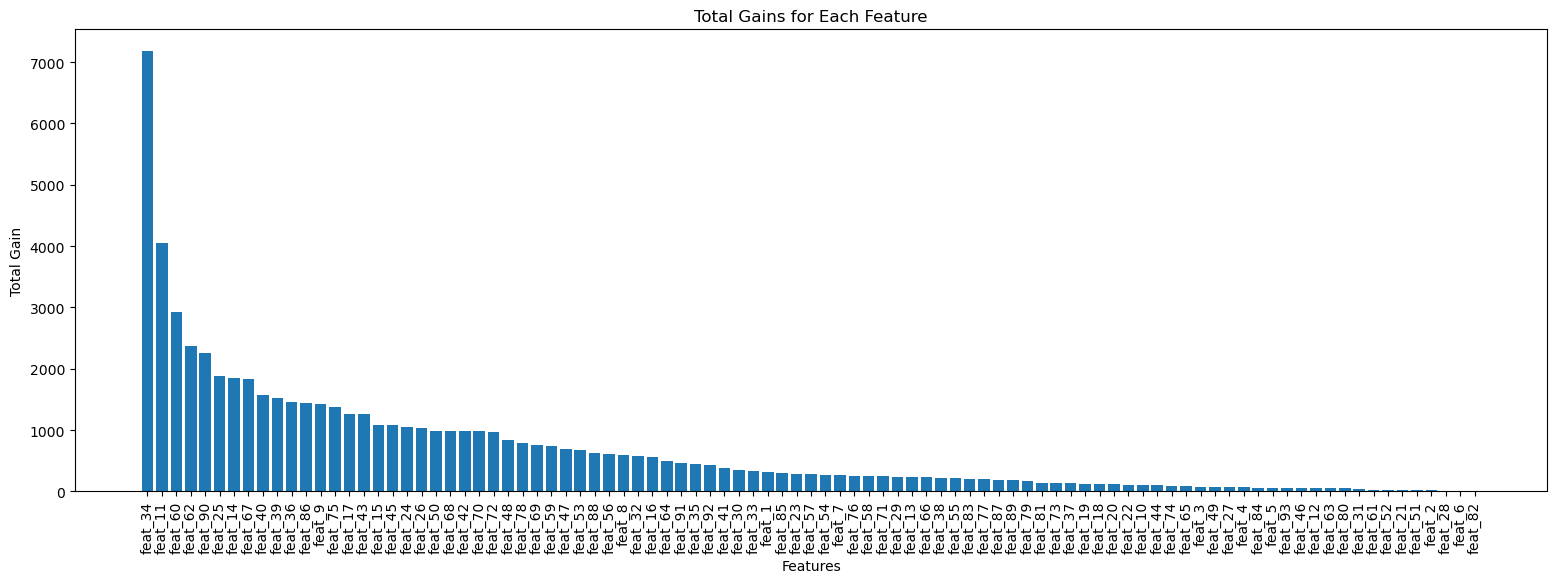

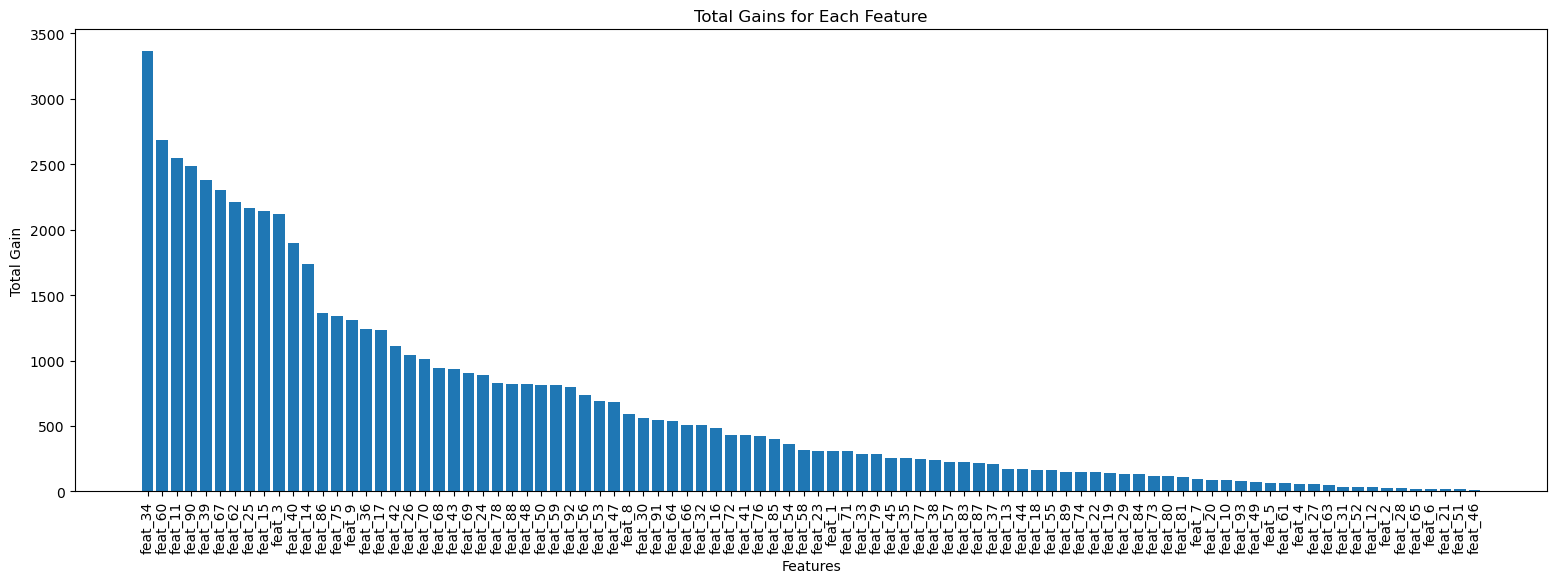

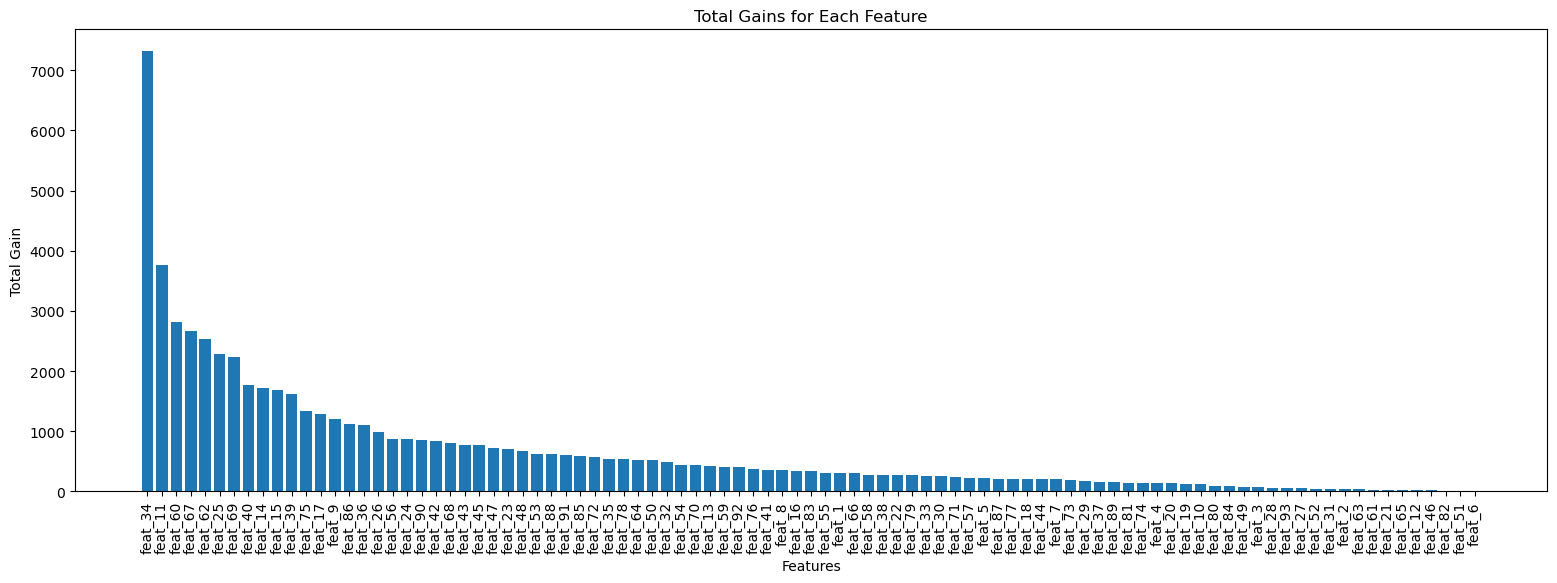

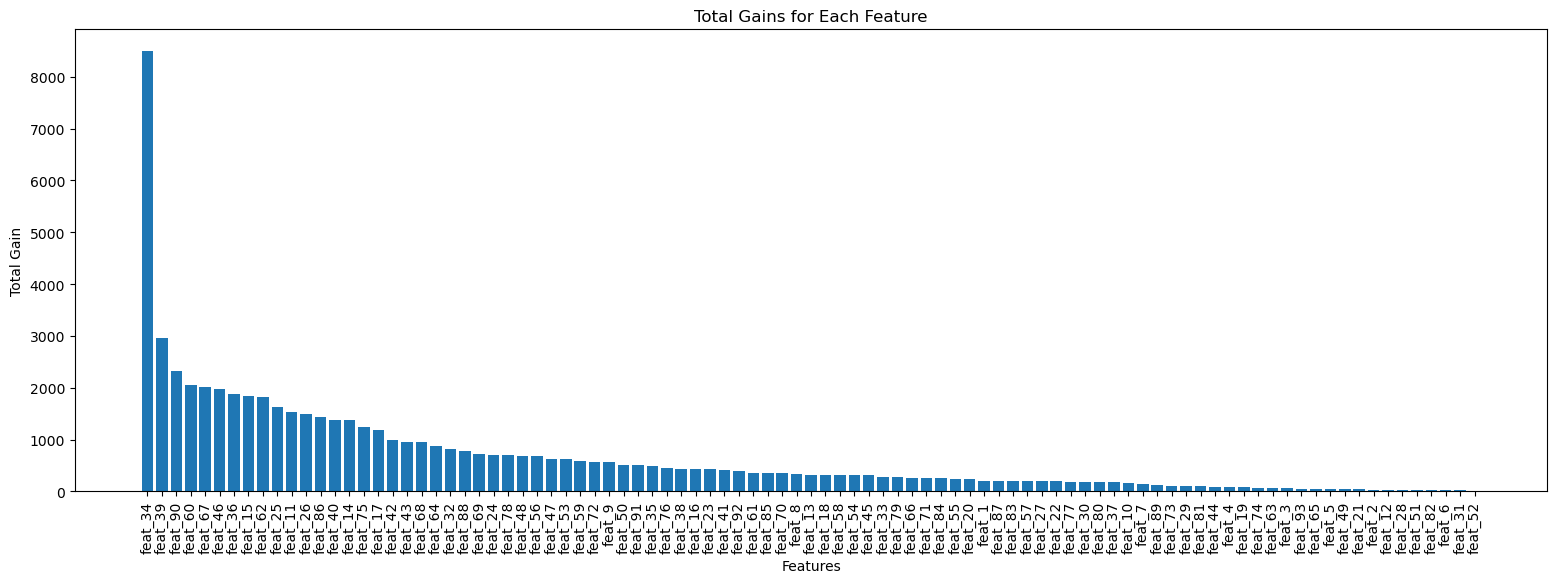

In [21]:
for i in range(5):
    fold_feat_imp = feature_importances[f"fold_{i + 1}"]
    # Sort
    fold_feat_imp_sorted = sorted(
        fold_feat_imp.items(), key=lambda key_val: key_val[1], reverse=True
    )
    fold_feat_imp_sorted = dict(fold_feat_imp_sorted)
    # Plot the average total gains
    plt.figure(figsize=(19, 6))
    plt.bar(fold_feat_imp_sorted.keys(), fold_feat_imp_sorted.values())
    plt.xticks(rotation=90)
    plt.xlabel("Features")
    plt.ylabel("Total Gain")
    plt.title("Total Gains for Each Feature")
    plt.show()

In [ ]:
# Convert to pandas
X, y = X.to_pandas(), y.to_pandas()

### Top 15 Features

Find the union of top 15 important features across all folds:

In [25]:
top_15_feat_union_set = []

for fold in range(5):
    fold_feat_imp = feature_importances[f"fold_{i + 1}"]

    fold_feat_imp_sorted = sorted(
        fold_feat_imp.items(), key=lambda key_val: key_val[1], reverse=True
    )

    fold_feat_imp_sorted = dict(fold_feat_imp_sorted)

    top_15_feat_union_set.append(list(fold_feat_imp_sorted.keys())[:15])

top_15_feat_union_set = reduce(np.union1d, top_15_feat_union_set)

top_15_feat_union_set

array(['feat_11', 'feat_14', 'feat_15', 'feat_25', 'feat_26', 'feat_34',
       'feat_36', 'feat_39', 'feat_40', 'feat_46', 'feat_60', 'feat_62',
       'feat_67', 'feat_86', 'feat_90'], dtype='<U7')

For these features, we can take the second and third order polynomials once we exclude the top five.

In [36]:
X.loc[:, top_15_feat_union_set].corr(method="spearman").style.background_gradient(
    cmap="coolwarm"
)

,feat_11,feat_14,feat_15,feat_25,feat_26,feat_34,feat_36,feat_39,feat_40,feat_46,feat_60,feat_62,feat_67,feat_86,feat_90
feat_11,1.000000,-0.152817,-0.125212,-0.265168,0.279223,0.000082,0.020242,0.091419,-0.157398,0.459373,0.176515,0.028630,-0.079834,-0.185596,0.134411
feat_14,-0.152817,1.000000,0.069969,0.497490,-0.144573,-0.086543,-0.013372,-0.045523,0.510540,-0.107940,-0.128844,0.046681,-0.118557,0.329226,-0.094518
feat_15,-0.125212,0.069969,1.000000,0.108279,-0.098149,-0.018514,-0.099226,-0.028117,0.159333,-0.063110,-0.111825,0.085983,-0.007010,0.072213,-0.097635
feat_25,-0.265168,0.497490,0.108279,1.000000,-0.194785,-0.113812,-0.016166,-0.064187,0.441905,-0.208697,-0.152814,0.109368,0.052916,0.417314,-0.160776
feat_26,0.279223,-0.144573,-0.098149,-0.194785,1.000000,0.033744,0.001930,-0.000800,-0.123067,0.349913,0.375473,0.071403,-0.077082,-0.180369,0.013110
feat_34,0.000082,-0.086543,-0.018514,-0.113812,0.033744,1.000000,0.013184,0.081256,-0.043781,0.022247,0.040523,0.121563,0.049668,-0.122636,-0.005687
feat_36,0.020242,-0.013372,-0.099226,-0.016166,0.001930,0.013184,1.000000,0.097888,-0.042557,-0.014451,0.079452,0.143567,0.335692,-0.018301,0.089202
feat_39,0.091419,-0.045523,-0.028117,-0.064187,-0.000800,0.081256,0.097888,1.000000,-0.046178,0.002329,0.072835,0.057083,0.195555,0.010386,0.167499
feat_40,-0.157398,0.510540,0.159333,0.441905,-0.123067,-0.043781,-0.042557,-0.046178,1.000000,-0.078924,-0.138648,0.203064,-0.135085,0.245814,-0.116059
feat_46,0.459373,-0.107940,-0.063110,-0.208697,0.349913,0.022247,-0.014451,0.002329,-0.078924,1.000000,0.148991,0.089951,-0.141168,-0.177882,0.022964


### Top 5 Features

Find the union of the top 5 most important features across all folds:

In [37]:
top_5_feat_union_set = []

for fold in range(5):
    fold_feat_imp = feature_importances[f"fold_{i + 1}"]

    fold_feat_imp_sorted = sorted(
        fold_feat_imp.items(), key=lambda key_val: key_val[1], reverse=True
    )

    fold_feat_imp_sorted = dict(fold_feat_imp_sorted)

    top_5_feat_union_set.append(list(fold_feat_imp_sorted.keys())[:5])

top_5_feat_union_set = reduce(np.union1d, top_5_feat_union_set)

top_5_feat_union_set

array(['feat_34', 'feat_39', 'feat_60', 'feat_67', 'feat_90'], dtype='<U7')

In [38]:
X.loc[:, top_5_feat_union_set].corr(method="spearman").style.background_gradient(
    cmap="coolwarm"
)

,feat_34,feat_39,feat_60,feat_67,feat_90
feat_34,1.000000,0.081256,0.040523,0.049668,-0.005687
feat_39,0.081256,1.000000,0.072835,0.195555,0.167499
feat_60,0.040523,0.072835,1.000000,0.096058,0.077137
feat_67,0.049668,0.195555,0.096058,1.000000,0.091151
feat_90,-0.005687,0.167499,0.077137,0.091151,1.000000


For the top 5 most important features, we can generate new features as follows:

* pairwise interaction 
    - multiplication
    - division
    - summation
    - difference

* polynomial second or third order

In [39]:
# Take the intersection of the two sets for the first group of features
polynomial_features = np.setdiff1d(top_15_feat_union_set, top_5_feat_union_set)

# The second group will be interacted with each other in addition to polynomial features
int_poly_features = top_5_feat_union_set

In [40]:
polynomial_features, int_poly_features

(array(['feat_11', 'feat_14', 'feat_15', 'feat_25', 'feat_26', 'feat_36',
        'feat_40', 'feat_46', 'feat_62', 'feat_86'], dtype='<U7'),
 array(['feat_34', 'feat_39', 'feat_60', 'feat_67', 'feat_90'], dtype='<U7'))

## Clean-up

In [41]:
sm_boto3.close()

s3.close()